In [9]:
# Cell 1: Imports and Setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
import os
import logging
import datetime as dt # For type hinting if needed, pandas handles most conversions

# --- Logging Setup ---
logger_eda = logging.getLogger("eda_backtest_logs")
if not logger_eda.handlers:
    logger_eda.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(name)s - %(message)s')
    ch = logging.StreamHandler()
    ch.setFormatter(formatter)
    logger_eda.addHandler(ch)
else:
    logger_eda.setLevel(logging.INFO)

# --- Directories ---
# Assuming this notebook is in /notebooks/eda/
# Adjust if your notebook is elsewhere relative to the project root.
BASE_PROJECT_DIR = Path("/Users/omarabul-hassan/Desktop/projects/kalshi")
NOTEBOOKS_DIR = BASE_PROJECT_DIR / "notebooks"
BACKTEST_DIR = NOTEBOOKS_DIR / "backtest"
LOG_DIR_FROM_BACKTEST = BACKTEST_DIR / "logs" # Where the trade logs are saved

# --- Plotting Style ---
plt.style.use('seaborn-v0_8-whitegrid') # Using a seaborn style
sns.set_palette("pastel")

logger_eda.info(f"Trade logs expected from: {LOG_DIR_FROM_BACKTEST}")
logger_eda.info("EDA Setup complete.")

2025-05-22 19:17:48,911 - INFO - eda_backtest_logs - Trade logs expected from: /Users/omarabul-hassan/Desktop/projects/kalshi/notebooks/backtest/logs
2025-05-22 19:17:48,917 - INFO - eda_backtest_logs - EDA Setup complete.


In [10]:
# Cell 2: Load and Consolidate Trade Logs

if not LOG_DIR_FROM_BACKTEST.exists():
    logger_eda.error(f"Trade log directory not found: {LOG_DIR_FROM_BACKTEST}")
    all_trades_df = pd.DataFrame() # Create empty df to prevent errors later
else:
    log_files = sorted(list(LOG_DIR_FROM_BACKTEST.glob("*_trades.csv")))
    
    if not log_files:
        logger_eda.warning(f"No trade log CSV files found in {LOG_DIR_FROM_BACKTEST}.")
        all_trades_df = pd.DataFrame()
    else:
        logger_eda.info(f"Found {len(log_files)} trade log files. Consolidating...")
        df_list = []
        for log_file in log_files:
            try:
                daily_df = pd.read_csv(log_file)
                if not daily_df.empty:
                    # Extract date from filename for verification or grouping if needed
                    daily_df['log_file_date_str'] = log_file.stem.split('_trades')[0]
                    df_list.append(daily_df)
                else:
                    logger_eda.info(f"Log file {log_file.name} is empty.")
            except Exception as e:
                logger_eda.error(f"Error reading log file {log_file.name}: {e}")
        
        if df_list:
            all_trades_df = pd.concat(df_list, ignore_index=True)
            logger_eda.info(f"Consolidated {len(all_trades_df)} trades from {len(df_list)} non-empty log files.")
            
            # --- Data Type Conversions and Basic Cleaning ---
            # Convert timestamps
            all_trades_df['trade_execution_time_utc'] = pd.to_datetime(all_trades_df['trade_execution_time_utc'])
            all_trades_df['decision_timestamp_s'] = pd.to_numeric(all_trades_df['decision_timestamp_s'])
            all_trades_df['resolution_time_ts'] = pd.to_numeric(all_trades_df['resolution_time_ts'])

            # Ensure numeric types for P&L, costs etc.
            numeric_cols = ['strike_price', 'predicted_prob_yes', 'bet_cost_cents', 
                            'contracts_traded', 'kalshi_outcome_target', 'pnl_cents', 
                            'time_to_resolution_minutes']
            for col in numeric_cols:
                if col in all_trades_df.columns:
                    all_trades_df[col] = pd.to_numeric(all_trades_df[col], errors='coerce')
            
            # Sort by trade execution time
            all_trades_df.sort_values(by='trade_execution_time_utc', inplace=True)
            all_trades_df.reset_index(drop=True, inplace=True)

            logger_eda.info("Data types converted and trades sorted.")
            display(all_trades_df.head())
            # logger_eda.info(all_trades_df.info()) # For detailed type check
        else:
            logger_eda.info("No trade data loaded from log files.")
            all_trades_df = pd.DataFrame()

if all_trades_df.empty:
    logger_eda.warning("No trade data to analyze.")

2025-05-22 19:17:48,943 - INFO - eda_backtest_logs - Found 7 trade log files. Consolidating...
2025-05-22 19:17:49,117 - INFO - eda_backtest_logs - Consolidated 196654 trades from 7 non-empty log files.
2025-05-22 19:17:49,150 - INFO - eda_backtest_logs - Data types converted and trades sorted.


,trade_execution_time_utc,market_ticker,strike_price,resolution_time_ts,decision_timestamp_s,time_to_resolution_minutes,action,predicted_prob_yes,bet_cost_cents,contracts_traded,kalshi_outcome_target,pnl_cents,log_file_date_str
0,2025-05-09 00:00:00+00:00,KXBTCD-25MAY0917-T100999.99,100999.99,1746824400,1746748800,1260.0,BUY_YES,0.9476,94,1,1,6,2025-05-09
1,2025-05-09 00:00:00+00:00,KXBTCD-25MAY0917-T105499.99,105499.99,1746824400,1746748800,1260.0,BUY_NO,0.3094,69,1,0,31,2025-05-09
2,2025-05-09 00:00:00+00:00,KXBTCD-25MAY0917-T102999.99,102999.99,1746824400,1746748800,1260.0,BUY_YES,0.7268,72,1,1,28,2025-05-09
3,2025-05-09 00:00:00+00:00,KXBTCD-25MAY0917-T104999.99,104999.99,1746824400,1746748800,1260.0,BUY_NO,0.3669,63,1,0,37,2025-05-09
4,2025-05-09 00:00:00+00:00,KXBTCD-25MAY0917-T102499.99,102499.99,1746824400,1746748800,1260.0,BUY_YES,0.8180,81,1,1,19,2025-05-09


In [11]:
# Cell 3: Overall Performance Metrics

if not all_trades_df.empty:
    total_pnl_cents = all_trades_df['pnl_cents'].sum()
    total_trades = len(all_trades_df)
    
    wins = all_trades_df[all_trades_df['pnl_cents'] > 0]
    losses = all_trades_df[all_trades_df['pnl_cents'] < 0]
    num_wins = len(wins)
    num_losses = len(losses)
    
    win_rate = num_wins / total_trades if total_trades > 0 else 0
    
    avg_pnl_per_trade_cents = all_trades_df['pnl_cents'].mean() if total_trades > 0 else 0
    avg_win_cents = wins['pnl_cents'].mean() if num_wins > 0 else 0
    avg_loss_cents = losses['pnl_cents'].mean() if num_losses > 0 else 0 # Will be negative
    
    profit_factor = wins['pnl_cents'].sum() / abs(losses['pnl_cents'].sum()) if num_losses > 0 and losses['pnl_cents'].sum() !=0 else np.inf

    logger_eda.info("--- Overall Backtest Performance ---")
    logger_eda.info(f"Total Trades: {total_trades}")
    logger_eda.info(f"Total P&L: {total_pnl_cents / 100:.2f} USD")
    logger_eda.info(f"Number of Wins: {num_wins}")
    logger_eda.info(f"Number of Losses: {num_losses}")
    logger_eda.info(f"Win Rate: {win_rate:.2%}")
    logger_eda.info(f"Average P&L per Trade: {avg_pnl_per_trade_cents / 100:.4f} USD")
    logger_eda.info(f"Average Win Amount: {avg_win_cents / 100:.2f} USD (when winning)")
    logger_eda.info(f"Average Loss Amount: {avg_loss_cents / 100:.2f} USD (when losing)")
    logger_eda.info(f"Profit Factor: {profit_factor:.2f}")

    # Display as a DataFrame for clarity
    summary_data = {
        "Metric": ["Total Trades", "Total P&L (USD)", "Num Wins", "Num Losses", "Win Rate", 
                   "Avg P&L/Trade (USD)", "Avg Win (USD)", "Avg Loss (USD)", "Profit Factor"],
        "Value": [total_trades, f"{total_pnl_cents / 100:.2f}", num_wins, num_losses, f"{win_rate:.2%}",
                  f"{avg_pnl_per_trade_cents / 100:.4f}", f"{avg_win_cents / 100:.2f}", 
                  f"{avg_loss_cents / 100:.2f}", f"{profit_factor:.2f}"]
    }
    summary_df = pd.DataFrame(summary_data)
    display(summary_df)
    
else:
    logger_eda.warning("all_trades_df is empty. Cannot calculate overall performance.")
    

2025-05-22 19:17:49,170 - INFO - eda_backtest_logs - --- Overall Backtest Performance ---
2025-05-22 19:17:49,170 - INFO - eda_backtest_logs - Total Trades: 196654
2025-05-22 19:17:49,171 - INFO - eda_backtest_logs - Total P&L: 5989.55 USD
2025-05-22 19:17:49,171 - INFO - eda_backtest_logs - Number of Wins: 183311
2025-05-22 19:17:49,171 - INFO - eda_backtest_logs - Number of Losses: 13343
2025-05-22 19:17:49,171 - INFO - eda_backtest_logs - Win Rate: 93.21%
2025-05-22 19:17:49,172 - INFO - eda_backtest_logs - Average P&L per Trade: 0.0305 USD
2025-05-22 19:17:49,172 - INFO - eda_backtest_logs - Average Win Amount: 0.09 USD (when winning)
2025-05-22 19:17:49,173 - INFO - eda_backtest_logs - Average Loss Amount: -0.77 USD (when losing)
2025-05-22 19:17:49,173 - INFO - eda_backtest_logs - Profit Factor: 1.58


,Metric,Value
0,Total Trades,196654
1,Total P&L (USD),5989.55
2,Num Wins,183311
3,Num Losses,13343
4,Win Rate,93.21%
5,Avg P&L/Trade (USD),0.0305
6,Avg Win (USD),0.09
7,Avg Loss (USD),-0.77
8,Profit Factor,1.58


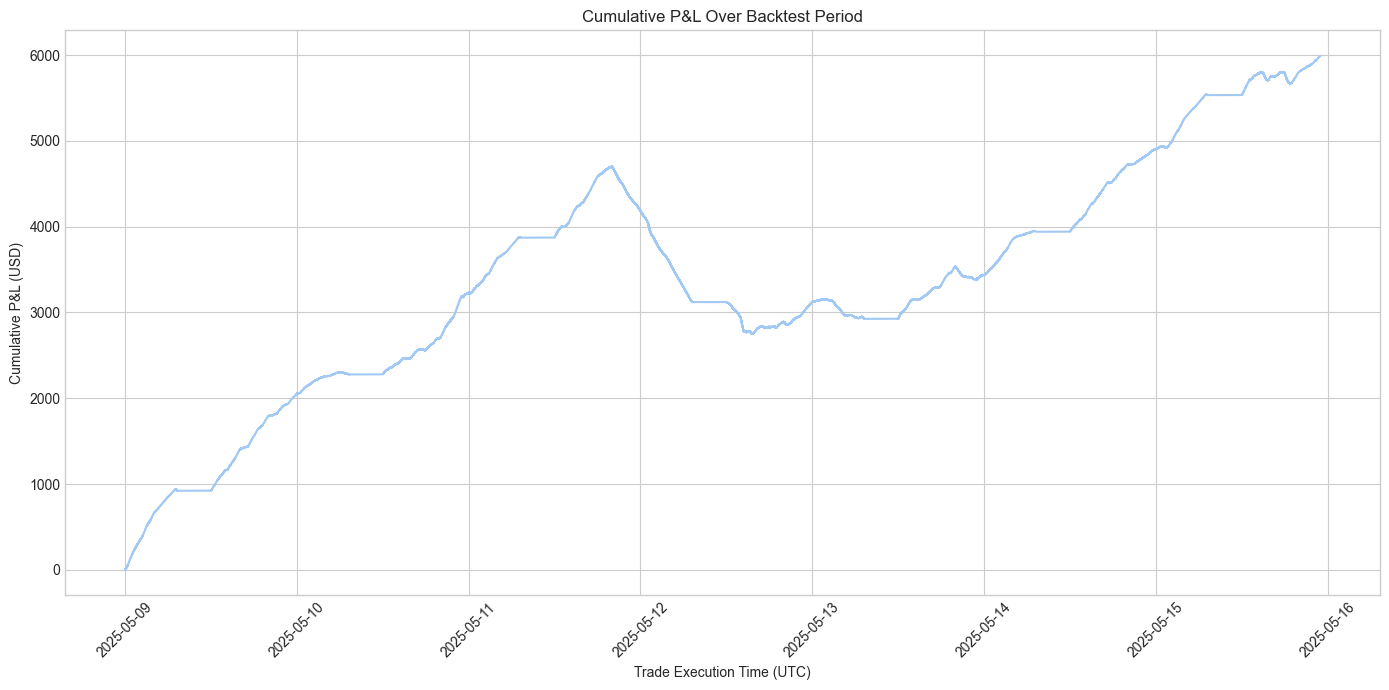

In [12]:
# Cell 4: P&L Over Time (Equity Curve)

if not all_trades_df.empty and 'pnl_cents' in all_trades_df.columns and 'trade_execution_time_utc' in all_trades_df.columns:
    all_trades_df['cumulative_pnl_cents'] = all_trades_df['pnl_cents'].cumsum()
    
    plt.figure(figsize=(14, 7))
    plt.plot(all_trades_df['trade_execution_time_utc'], all_trades_df['cumulative_pnl_cents'] / 100.0) # Convert to USD
    plt.title('Cumulative P&L Over Backtest Period')
    plt.xlabel('Trade Execution Time (UTC)')
    plt.ylabel('Cumulative P&L (USD)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()
else:
    logger_eda.warning("Cannot plot equity curve: DataFrame empty or required columns missing.")

2025-05-22 19:17:49,894 - INFO - eda_backtest_logs - 
--- Daily Performance ---


,decision_date,total_trades_daily,total_pnl_usd_daily,win_rate_daily
0,2025-05-09,26536,2050.53,0.969815
1,2025-05-10,27131,1179.96,0.944344
2,2025-05-11,30441,956.34,0.933839
3,2025-05-12,29018,-1063.63,0.877869
4,2025-05-13,28819,314.54,0.906208
5,2025-05-14,29069,1465.81,0.954832
6,2025-05-15,25640,1086.00,0.943136


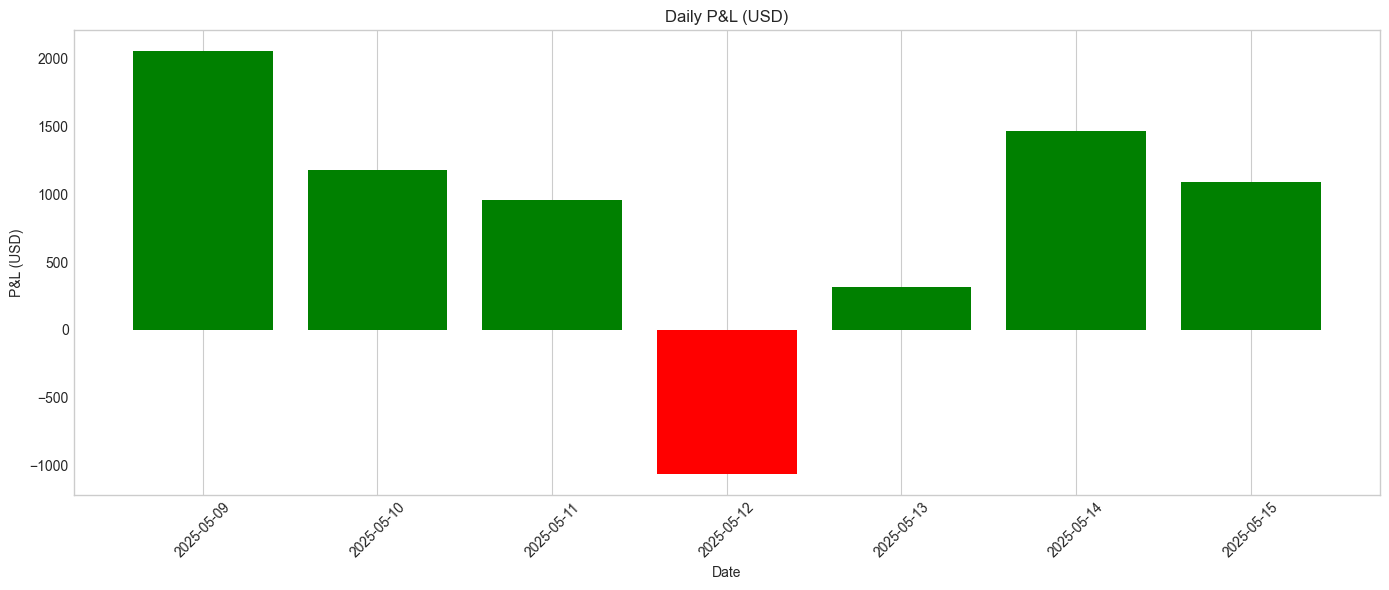

In [13]:
# Cell 5: Performance by Day

if not all_trades_df.empty and 'trade_execution_time_utc' in all_trades_df.columns:
    # Extract just the date part for grouping
    all_trades_df['decision_date'] = all_trades_df['trade_execution_time_utc'].dt.date
    
    daily_performance = all_trades_df.groupby('decision_date').agg(
        total_trades_daily=('market_ticker', 'count'),
        total_pnl_cents_daily=('pnl_cents', 'sum'),
        win_rate_daily=('pnl_cents', lambda x: (x > 0).sum() / x.count() if x.count() > 0 else 0)
    ).reset_index()
    
    daily_performance['total_pnl_usd_daily'] = daily_performance['total_pnl_cents_daily'] / 100.0
    
    logger_eda.info("\n--- Daily Performance ---")
    display(daily_performance[['decision_date', 'total_trades_daily', 'total_pnl_usd_daily', 'win_rate_daily']])
    
    # Plot daily P&L
    plt.figure(figsize=(14, 6))
    plt.bar(daily_performance['decision_date'].astype(str), daily_performance['total_pnl_usd_daily'], 
            color=np.where(daily_performance['total_pnl_usd_daily'] >= 0, 'g', 'r'))
    plt.title('Daily P&L (USD)')
    plt.xlabel('Date')
    plt.ylabel('P&L (USD)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(axis='y')
    plt.show()
    
else:
    logger_eda.warning("Cannot analyze daily performance: DataFrame empty or required columns missing.")

In [14]:
# Cell 6: Analysis by Trade Action (BUY_YES vs BUY_NO)

if not all_trades_df.empty and 'action' in all_trades_df.columns:
    action_performance = all_trades_df.groupby('action').agg(
        count=('market_ticker', 'size'),
        total_pnl_cents=('pnl_cents', 'sum'),
        avg_pnl_per_trade_cents=('pnl_cents', 'mean'),
        win_count=('pnl_cents', lambda x: (x > 0).sum()),
        loss_count=('pnl_cents', lambda x: (x < 0).sum())
    ).reset_index()
    
    action_performance['win_rate'] = action_performance['win_count'] / (action_performance['win_count'] + action_performance['loss_count'])
    action_performance['total_pnl_usd'] = action_performance['total_pnl_cents'] / 100.0
    action_performance['avg_pnl_per_trade_usd'] = action_performance['avg_pnl_per_trade_cents'] / 100.0
    
    logger_eda.info("\n--- Performance by Trade Action ---")
    display(action_performance[['action', 'count', 'total_pnl_usd', 'avg_pnl_per_trade_usd', 'win_rate']])
else:
    logger_eda.warning("Cannot analyze by trade action: DataFrame empty or 'action' column missing.")

2025-05-22 19:17:49,961 - INFO - eda_backtest_logs - 
--- Performance by Trade Action ---


,action,count,total_pnl_usd,avg_pnl_per_trade_usd,win_rate
0,BUY_NO,89827,7188.44,0.080025,0.958899
1,BUY_YES,106827,-1198.89,-0.011223,0.909658


2025-05-22 19:17:49,969 - INFO - eda_backtest_logs - 
--- Predicted Probability Analysis ---


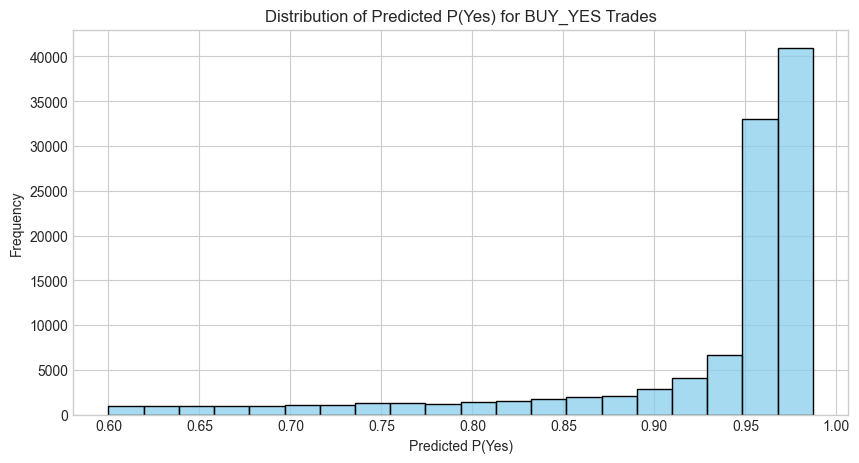

/var/folders/43/br9zl9l149d3rb94gdkr1wsm0000gn/T/ipykernel_35089/367248623.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy_no_trades['predicted_prob_no'] = 1 - buy_no_trades['predicted_prob_yes']


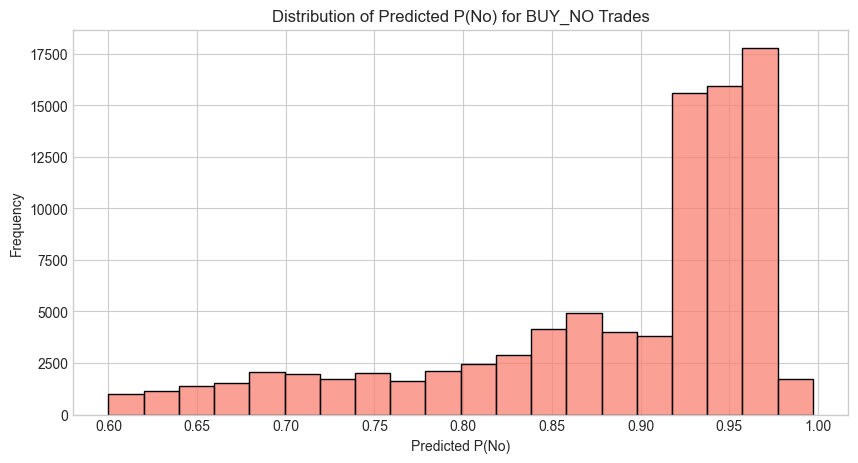

2025-05-22 19:17:50,761 - INFO - eda_backtest_logs - 
--- P&L and Win Rate by Binned Model Confidence (in bet direction) ---


,prob_bin,count,avg_pnl_cents,win_rate,avg_pnl_usd
0,"[0.5, 0.55)",0,NaN,0.000000,NaN
1,"[0.55, 0.6)",4,15.000000,0.750000,0.150000
2,"[0.6, 0.65)",5245,-1.238894,0.608389,-0.012389
3,"[0.65, 0.7)",6949,6.426104,0.735789,0.064261
4,"[0.7, 0.75)",7640,2.524869,0.745550,0.025249
5,"[0.75, 0.8)",8023,-1.776019,0.752960,-0.017760
6,"[0.8, 0.85)",11456,2.910527,0.851344,0.029105
7,"[0.85, 0.9)",16698,3.593125,0.905438,0.035931
8,"[0.9, 0.95)",43782,3.322416,0.959984,0.033224
9,"[0.95, 1.0)",96857,3.271772,0.994920,0.032718


In [15]:
# Cell 7: Analysis by Predicted Probability

if not all_trades_df.empty and 'predicted_prob_yes' in all_trades_df.columns:
    logger_eda.info("\n--- Predicted Probability Analysis ---")
    
    # Distribution of predicted probabilities for BUY_YES trades
    buy_yes_trades = all_trades_df[all_trades_df['action'] == 'BUY_YES']
    if not buy_yes_trades.empty:
        plt.figure(figsize=(10, 5))
        sns.histplot(buy_yes_trades['predicted_prob_yes'], bins=20, kde=False, color='skyblue')
        plt.title('Distribution of Predicted P(Yes) for BUY_YES Trades')
        plt.xlabel('Predicted P(Yes)')
        plt.ylabel('Frequency')
        plt.show()
    else:
        logger_eda.info("No BUY_YES trades to analyze for probability distribution.")

    # Distribution of predicted P(No) (1 - P(Yes)) for BUY_NO trades
    buy_no_trades = all_trades_df[all_trades_df['action'] == 'BUY_NO']
    if not buy_no_trades.empty:
        buy_no_trades['predicted_prob_no'] = 1 - buy_no_trades['predicted_prob_yes']
        plt.figure(figsize=(10, 5))
        sns.histplot(buy_no_trades['predicted_prob_no'], bins=20, kde=False, color='salmon')
        plt.title('Distribution of Predicted P(No) for BUY_NO Trades')
        plt.xlabel('Predicted P(No)')
        plt.ylabel('Frequency')
        plt.show()
    else:
        logger_eda.info("No BUY_NO trades to analyze for probability distribution.")
        
    # P&L vs. Predicted Probability (binned)
    # Create bins for predicted_prob_yes
    # For BUY_YES, use predicted_prob_yes. For BUY_NO, use 1 - predicted_prob_yes (i.e. P(No))
    # Let's create a 'confidence_in_bet_direction' column
    
    def calculate_confidence(row):
        if row['action'] == 'BUY_YES':
            return row['predicted_prob_yes']
        elif row['action'] == 'BUY_NO':
            return 1 - row['predicted_prob_yes']
        return np.nan
        
    all_trades_df['confidence_in_bet_direction'] = all_trades_df.apply(calculate_confidence, axis=1)
    
    if 'confidence_in_bet_direction' in all_trades_df.columns and not all_trades_df['confidence_in_bet_direction'].isnull().all():
        all_trades_df['prob_bin'] = pd.cut(all_trades_df['confidence_in_bet_direction'], bins=np.arange(0.5, 1.01, 0.05), right=False) # Bins from 0.5-0.55, 0.55-0.6 etc.
    
        binned_pnl = all_trades_df.groupby('prob_bin', observed=False).agg(
            count=('market_ticker', 'size'),
            avg_pnl_cents=('pnl_cents', 'mean'),
            win_rate=('pnl_cents', lambda x: (x > 0).sum() / x.count() if x.count() > 0 else 0)
        ).reset_index()
        binned_pnl['avg_pnl_usd'] = binned_pnl['avg_pnl_cents'] / 100.0
        
        logger_eda.info("\n--- P&L and Win Rate by Binned Model Confidence (in bet direction) ---")
        display(binned_pnl)
    else:
        logger_eda.info("Could not perform binned probability analysis.")
else:
    logger_eda.warning("Cannot analyze by predicted probability: DataFrame empty or 'predicted_prob_yes' column missing.")

2025-05-22 19:17:50,769 - INFO - eda_backtest_logs - 
--- Performance by Time to Resolution at Decision ---
2025-05-22 19:17:50,778 - INFO - eda_backtest_logs - 
--- P&L and Win Rate by Time to Resolution Bin ---


,time_to_res_bin,count,total_pnl_usd,avg_pnl_usd,win_rate
0,0-1min,0,0.00,NaN,0.000000
1,1-3min,4411,198.59,0.045022,0.996146
2,3-5min,4388,194.24,0.044266,0.992479
3,5-10min,10883,440.25,0.040453,0.986217
4,10-15min,10686,413.15,0.038663,0.979693
5,15-30min,31757,1264.07,0.039804,0.972384
6,30-45min,31535,1144.35,0.036288,0.962010
7,45+ min,102994,2334.90,0.022670,0.894644


/var/folders/43/br9zl9l149d3rb94gdkr1wsm0000gn/T/ipykernel_35089/411204623.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=time_binned_performance, x='time_to_res_bin', y='avg_pnl_usd', palette="viridis")


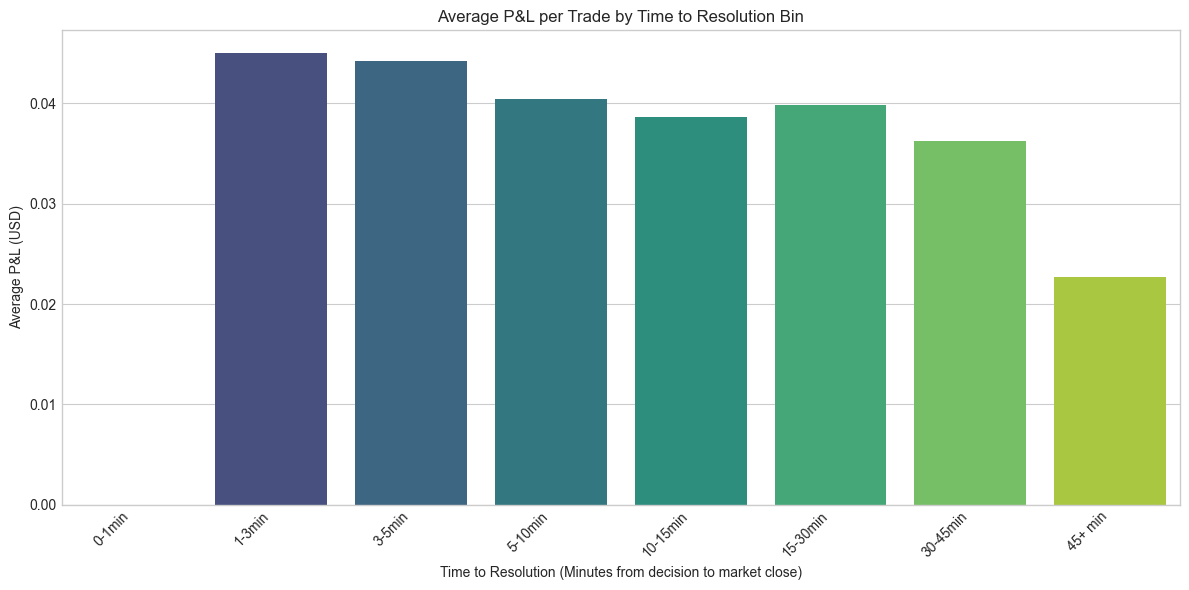

In [16]:
# Cell 8: Analysis by `time_to_resolution_minutes`

if not all_trades_df.empty and 'time_to_resolution_minutes' in all_trades_df.columns:
    logger_eda.info("\n--- Performance by Time to Resolution at Decision ---")
    
    # Create bins for time_to_resolution_minutes
    # Example bins: (0-5], (5-15], (15-30], (30-60], (60+]
    # The max time_to_resolution in your sample was ~1500 minutes.
    # Let's use broader bins for hourly markets.
    time_bins = [0, 5, 15, 30, 45, 60, np.inf] 
    time_labels = ['0-5min', '5-15min', '15-30min', '30-45min', '45-60min', '60+min'] 
    
    # For per-minute, more granular bins might be better for the first hour
    # time_bins = [0, 1, 3, 5, 10, 15, 30, 45, 59, np.inf]
    # time_labels = ['T-1m','T-3m','T-5m','T-10m','T-15m','T-30m','T-45m', 'T-59m', 'Earlier']
    # Using your feature engineering deltas: [1, 3, 5, 10, 15, 30, 45]
    time_bins_from_features = sorted([0] + list(set(ft_delta for ft_delta in [1,3,5,10,15,30,45] if ft_delta > 0))) + [np.inf]
    time_labels_from_features = []
    for i in range(len(time_bins_from_features)-1):
        if time_bins_from_features[i+1] == np.inf:
            time_labels_from_features.append(f"{time_bins_from_features[i]}+ min")
        else:
            time_labels_from_features.append(f"{time_bins_from_features[i]}-{time_bins_from_features[i+1]}min")


    all_trades_df['time_to_res_bin'] = pd.cut(all_trades_df['time_to_resolution_minutes'], 
                                              bins=time_bins_from_features, 
                                              labels=time_labels_from_features, 
                                              right=False, # [closed, open) interval
                                              include_lowest=True) # Include 0 if it occurs

    time_binned_performance = all_trades_df.groupby('time_to_res_bin', observed=False).agg(
        count=('market_ticker', 'size'),
        avg_pnl_cents=('pnl_cents', 'mean'),
        total_pnl_cents=('pnl_cents', 'sum'),
        win_rate=('pnl_cents', lambda x: (x > 0).sum() / x.count() if x.count() > 0 else 0)
    ).reset_index()
    time_binned_performance['avg_pnl_usd'] = time_binned_performance['avg_pnl_cents'] / 100.0
    time_binned_performance['total_pnl_usd'] = time_binned_performance['total_pnl_cents'] / 100.0
    
    logger_eda.info("\n--- P&L and Win Rate by Time to Resolution Bin ---")
    display(time_binned_performance[['time_to_res_bin', 'count', 'total_pnl_usd', 'avg_pnl_usd', 'win_rate']])

    # Plot average P&L per trade by time to resolution bin
    plt.figure(figsize=(12, 6))
    sns.barplot(data=time_binned_performance, x='time_to_res_bin', y='avg_pnl_usd', palette="viridis")
    plt.title('Average P&L per Trade by Time to Resolution Bin')
    plt.xlabel('Time to Resolution (Minutes from decision to market close)')
    plt.ylabel('Average P&L (USD)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    logger_eda.warning("Cannot analyze by time to resolution: DataFrame empty or column missing.")